In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score as sil_, calinski_harabasz_score as calinski_
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import re
from datetime import datetime, timezone
from sklearn.preprocessing import OneHotEncoder
import ipaddress
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from collections import Counter
import plotly.express as px
import matplotlib.dates as mdates
import folium
import pytz
from timezonefinder import TimezoneFinder
import pickle

c:\Users\lucch\Desktop\thesis-datasec\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/omnipot.csv')

In [3]:
df.drop_duplicates(inplace=True)

In [4]:
df.isna().sum()

src_port                0
dst_port                0
timestamp               0
src_as               2657
src_city                5
src_country             0
src_countryCode        42
src_geo_str             0
src_ip                  0
src_proxy               0
src_regionName        171
dst_as                  0
dst_city                0
dst_country             0
dst_countryCode         0
dst_geo_str             0
dst_ip                  0
dst_proxy               0
dst_regionName          0
protocol                0
payload_4kb_hex    209362
dtype: int64

In [5]:
df.dropna(subset="payload_4kb_hex", inplace=True)

In [6]:
df.shape

(468591, 21)

In [7]:
# ef bf bd is a very likely sign of the presence of so a corrupted payload �
df[df['payload_4kb_hex'].str.contains("efbfbd", na=False)].shape

(296419, 21)

In [8]:
import binascii

def is_probably_corrupted(hex_str):
    try:
        raw_bytes = bytes.fromhex(hex_str)
        decoded = raw_bytes.decode('utf-8')
        return '�' in decoded  # Check for U+FFFD
    except:
        return False
    
df_suspect = df[df['payload_4kb_hex'].str.contains("efbfbd", na=False)].copy()
df_suspect['is_probably_corrupted'] = df_suspect['payload_4kb_hex'].apply(is_probably_corrupted)


In [9]:
df_suspect['is_probably_corrupted'].value_counts()

is_probably_corrupted
True    296419
Name: count, dtype: int64

In [10]:
df.drop(index=df[df['payload_4kb_hex'].str.contains("efbfbd", na=False)].index, inplace=True)

In [11]:
df

,src_port,dst_port,timestamp,src_as,src_city,src_country,src_countryCode,src_geo_str,src_ip,src_proxy,...,dst_as,dst_city,dst_country,dst_countryCode,dst_geo_str,dst_ip,dst_proxy,dst_regionName,protocol,payload_4kb_hex
2,13652,22,1743924731683,AS6939 Hurricane Electric LLC,Alameda,United States,US,-122.262|37.7688,184.105.247.252,False,...,"AS20473 The Constant Company, LLC",Querétaro City,Mexico,MX,-100.2899|20.5737,216.238.89.44,True,Querétaro,ssh,474554202f20485454502f312e310d0a486f73743a2032...
5,60497,22,1743924736244,AS6939 Hurricane Electric LLC,Fremont,United States,US,-121.931|37.49,64.62.197.112,False,...,"AS20473 The Constant Company, LLC",Atlanta,United States,US,-84.4455|33.7838,104.238.179.29,False,Georgia,ssh,474554202f20485454502f312e310d0a486f73743a2031...
12,38560,80,1738746131049,"AS14061 DigitalOcean, LLC",Singapore,Singapore,SG,103.695|1.32123,128.199.179.71,False,...,"AS20473 The Constant Company, LLC",Singapore,Singapore,SG,103.695|1.32123,45.32.124.12,False,South West,http,474554202f68656c6c6f20485454502f312e310d0a486f...
18,48162,443,1738746141314,AS63949 Akamai Connected Cloud,Fremont,United States,US,-122.0004|37.5625,45.33.109.8,False,...,"AS20473 The Constant Company, LLC",Querétaro City,Mexico,MX,-100.2899|20.5737,216.238.86.69,True,Querétaro,https,474554202f20485454502f312e310d0a486f73743a2032...
21,42914,80,1738746143899,"AS14061 DigitalOcean, LLC",Singapore,Singapore,SG,103.695|1.32123,128.199.170.18,False,...,"AS20473 The Constant Company, LLC",Singapore,Singapore,SG,103.695|1.32123,45.32.124.12,False,South West,http,474554202f68656c6c6f20485454502f312e310d0a486f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965074,42792,22,1743465456661,AS12400 Partner Communications Ltd.,Jerusalem,Israel,IL,35.2186|31.7674,84.95.208.63,False,...,"AS20473 The Constant Company, LLC",Amsterdam,The Netherlands,NL,4.6563|52.3891,95.179.186.46,False,North Holland,ssh,5353482d322e302d476f0d0a
965075,42786,22,1743465456525,AS12400 Partner Communications Ltd.,Jerusalem,Israel,IL,35.2186|31.7674,84.95.208.63,False,...,"AS20473 The Constant Company, LLC",Amsterdam,The Netherlands,NL,4.6563|52.3891,95.179.186.46,False,North Holland,ssh,5353482d322e302d476f0d0a
965076,42776,22,1743465456396,AS12400 Partner Communications Ltd.,Jerusalem,Israel,IL,35.2186|31.7674,84.95.208.63,False,...,"AS20473 The Constant Company, LLC",Amsterdam,The Netherlands,NL,4.6563|52.3891,95.179.186.46,False,North Holland,ssh,5353482d322e302d476f0d0a
965077,53924,443,1743465477010,"AS16509 Amazon.com, Inc.",Dublin,United States,US,-83.1141|40.0992,3.136.87.118,False,...,"AS20473 The Constant Company, LLC",Whitechapel,United Kingdom,GB,-0.0638|51.5128,95.179.201.146,False,England,https,5353482d322e302d476f0d0a


In [12]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

In [13]:
# filling payload nan with "" the ndrop nan that are not in the payload column as empty payloads are valid
df.fillna({"payload_4kb_hex":""}, inplace=True)
df.dropna(inplace=True)

In [14]:
def get_ip_encoding(ipv4):
    oct1, oct2, oct3, oct4 = ipv4.split('.')
    return  int(oct1), int(oct2), int(oct3), int(oct4)

df[['src_oct1', 'src_oct2', 'src_oct3', 'src_oct4']] = df["src_ip"].apply(get_ip_encoding).apply(pd.Series)
df[['dst_oct1', 'dst_oct2', 'dst_oct3', 'dst_oct4']] = df["dst_ip"].apply(get_ip_encoding).apply(pd.Series)

In [15]:
df["src_geo_str"] = df["src_geo_str"].str.split("|").apply(lambda lst: [float(x) for x in lst])
df["dst_geo_str"] = df["dst_geo_str"].str.split("|").apply(lambda lst: [float(x) for x in lst])

In [16]:
from scipy.stats import entropy

def get_payload_features(payload):
    default = {'length': 0, 'unique_bytes': 0, 'entropy': 0.0,
               'mean_byte': 0.0, 'std_byte': 0.0}
    if not isinstance(payload, str) or len(payload) == 0:
        return default
    try:
        data = bytes.fromhex(payload)
    except ValueError:
        return default
    length = len(data)
    if length == 0:
        return default
    arr = np.frombuffer(data, dtype=np.uint8)
    counts = np.bincount(arr, minlength=256)
    probs = counts / length

    probs = probs[probs > 0]
    ent = entropy(probs, base=2)
    mean = float(arr.mean())
    std = float(arr.std())
    return {
        'length': length,
        'unique_bytes': int(np.count_nonzero(counts)),
        'entropy': float(ent),
        'mean_byte': mean,
        'std_byte': std
    }

payload_feats = ['pl_length', 'pl_unique_bytes', 'pl_entropy', 'pl_mean_byte', 'pl_std_byte']
df[payload_feats] = df["payload_4kb_hex"].apply(get_payload_features).apply(pd.Series)


Payload Feature Summary Statistics:
                    count       mean        std  min        25%        50%  \
pl_unique_bytes  171261.0  24.613403  20.130762  1.0  10.000000  15.000000   
pl_entropy       171261.0   3.878729   1.184508  0.0   3.251629   3.762267   
pl_mean_byte     171261.0  60.978293  18.051363  0.0  56.416667  61.133333   
pl_std_byte      171261.0  28.994977   8.231735  0.0  25.899334  30.512365   

                       75%         max  
pl_unique_bytes  40.000000   83.000000  
pl_entropy        4.979388    6.059452  
pl_mean_byte     71.827103  112.833333  
pl_std_byte      32.277096   83.100712  


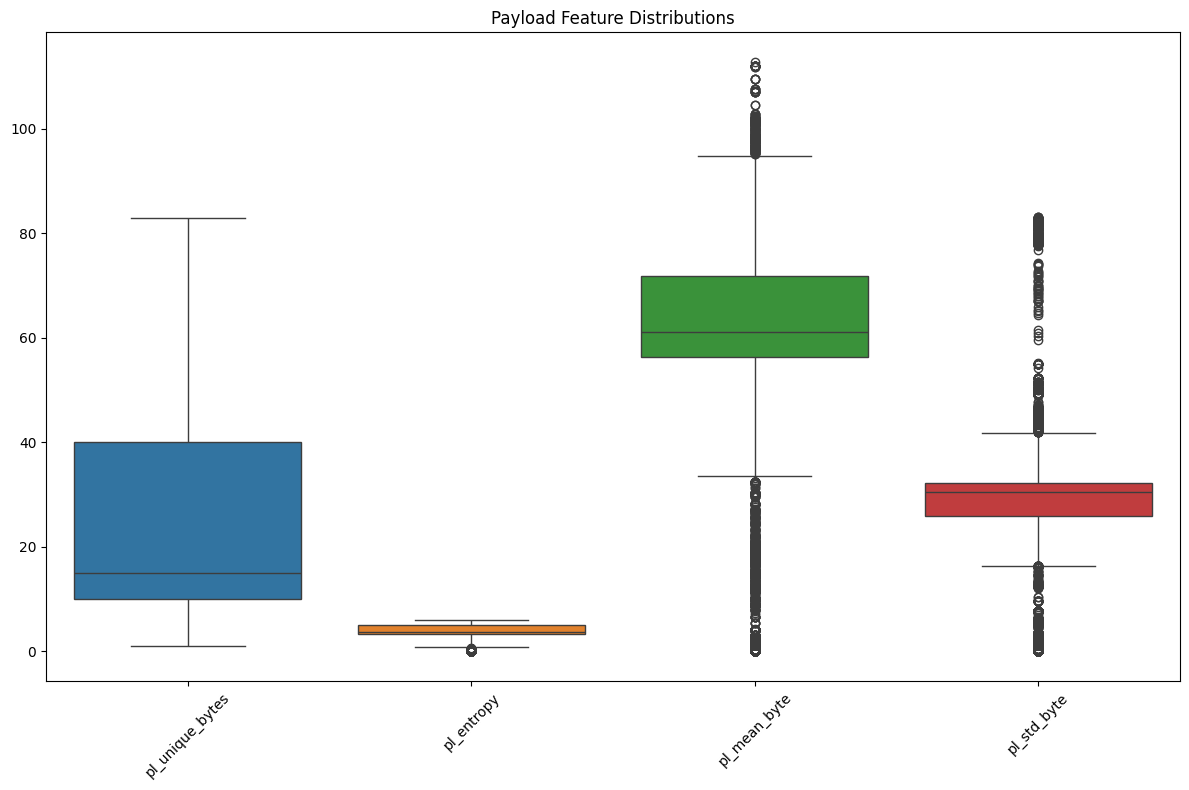

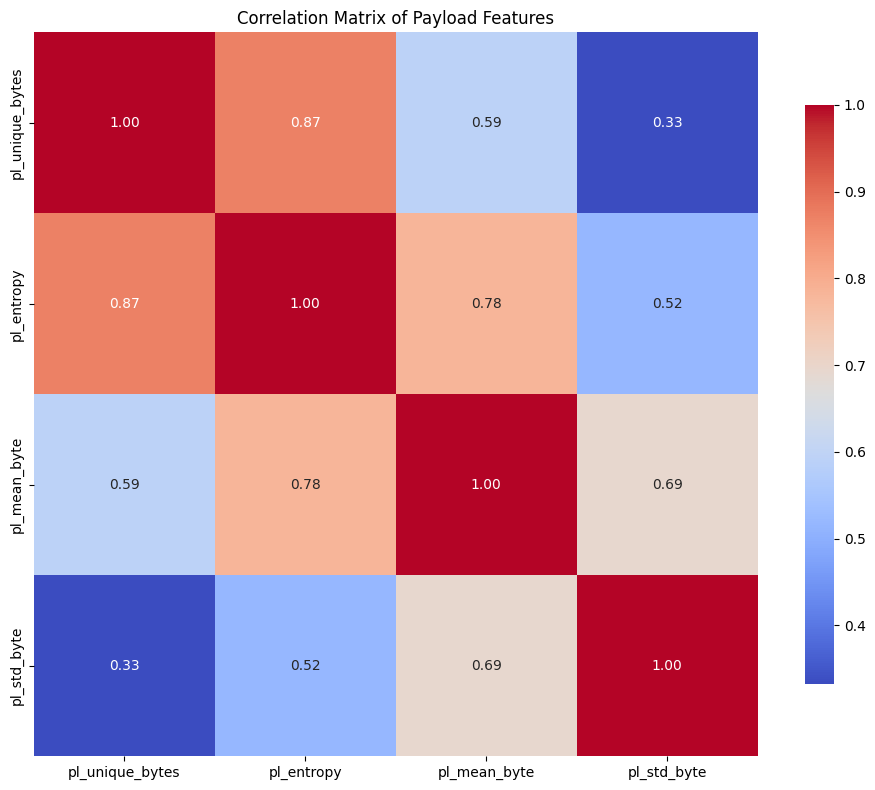

In [18]:
payload_feats = ['pl_unique_bytes', 'pl_entropy', 'pl_mean_byte', 'pl_std_byte']

plt.figure(figsize=(12, 8))
sns.boxplot(data=df[payload_feats])
plt.title('Payload Feature Distributions')
plt.xticks(rotation=45)
plt.tight_layout()

corr_matrix = df[payload_feats].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Payload Features')
plt.tight_layout()

print("\nPayload Feature Summary Statistics:")
print(df[payload_feats].describe().T)

In [17]:
def decode_payload(hex_str: str, protocol: str) -> str:
    if not hex_str or not isinstance(hex_str, str):
        return ""
    
    try:
        raw_bytes = bytes.fromhex(hex_str)
        if not raw_bytes:
            return ""

        # --- SSH ---
        if protocol == 'ssh':
            if raw_bytes.startswith(b'SSH-'):
                banner = raw_bytes.decode('utf-8', errors='ignore').split('\n')[0]
                return banner.strip()
            try:
                text = raw_bytes.decode('utf-8', errors='ignore')
                return f"SSH_FULL: {text.strip()}"
            except:
                return f"SSH_BINARY_{len(raw_bytes)}B"

        # --- HTTP/HTTPS ---
        elif protocol in ['http', 'https']:
            try:
                text = raw_bytes.decode('utf-8', errors='ignore')
                if text.strip():
                    return f"HTTP_FULL:\n{text.strip()}"
            except:
                pass
            return f"HTTP_BINARY_{len(raw_bytes)}B"

        # --- SMB ---
        elif protocol == 'smb':
            if len(raw_bytes) > 8:
                smb_commands = {
                    0x00: "SMB_NEGOTIATE",
                    0x73: "SMB_NEGOTIATE",
                    0x75: "SMB_TREE_CONNECT",
                    0x1d: "SMB_SESSION_SETUP",
                    0x25: "SMB_CREATE",
                    0x2e: "SMB_IOCTL",
                    0x32: "SMB_READ",
                    0x0b: "SMB_TREE_DISCONNECT"
                }
                cmd = smb_commands.get(raw_bytes[4], f"SMB_UNKNOWN_{raw_bytes[4]}")
                return cmd if cmd != "SMB_NEGOTIATE" or raw_bytes[4:8] == b'\xffSMB' else "SMB_INVALID"
            return "SMB_EMPTY"

        # --- FTP ---
        elif protocol == 'ftp' or b'USER ' in raw_bytes or b'PASS ' in raw_bytes:
            try:
                ftp_text = raw_bytes.decode('utf-8', errors='ignore')
                return f"FTP_FULL: {ftp_text.strip()}"
            except:
                return "FTP_BINARY"

        # --- SMTP ---
        elif protocol == 'smtp' or b'MAIL FROM' in raw_bytes or b'HELO' in raw_bytes:
            try:
                smtp_text = raw_bytes.decode('utf-8', errors='ignore')
                return f"SMTP_FULL: {smtp_text.strip()}"
            except:
                return "SMTP_BINARY"

        # --- Telnet ---
        elif protocol == 'telnet':
            try:
                telnet_text = raw_bytes.decode('utf-8', errors='ignore')
                return f"TELNET_FULL: {telnet_text.strip()}"
            except:
                return "TELNET_BINARY"

        # --- SSL/TLS (generic fallback) ---
        elif protocol == 'ssl' or (len(raw_bytes) > 0 and raw_bytes[0] == 0x16):
            return "SSL_HANDSHAKE"

        # --- Generic TCP fallback ---
        elif protocol == 'tcp':
            printable_ratio = sum(32 <= b <= 126 for b in raw_bytes) / len(raw_bytes)
            if printable_ratio > 0.8:
                return f"TCP_FULL: {raw_bytes.decode('utf-8', errors='ignore').strip()}"
            else:
                return f"TCP_BINARY_{len(raw_bytes)}B"

        # --- Default: Other / Unknown ---
        else:
            try:
                text = raw_bytes.decode('utf-8', errors='ignore')
                if text.strip():
                    return f"{protocol.upper()}_FULL: {text.strip()}"
            except:
                pass
            return f"{protocol.upper()}_BINARY_{len(raw_bytes)}B"

    except Exception as e:
        return f"DECODE_ERROR_{str(e)}"

# Apply decoding
df['payload_decoded'] = df.apply(
    lambda row: decode_payload(row['payload_4kb_hex'], row['protocol']), 
    axis=1
)

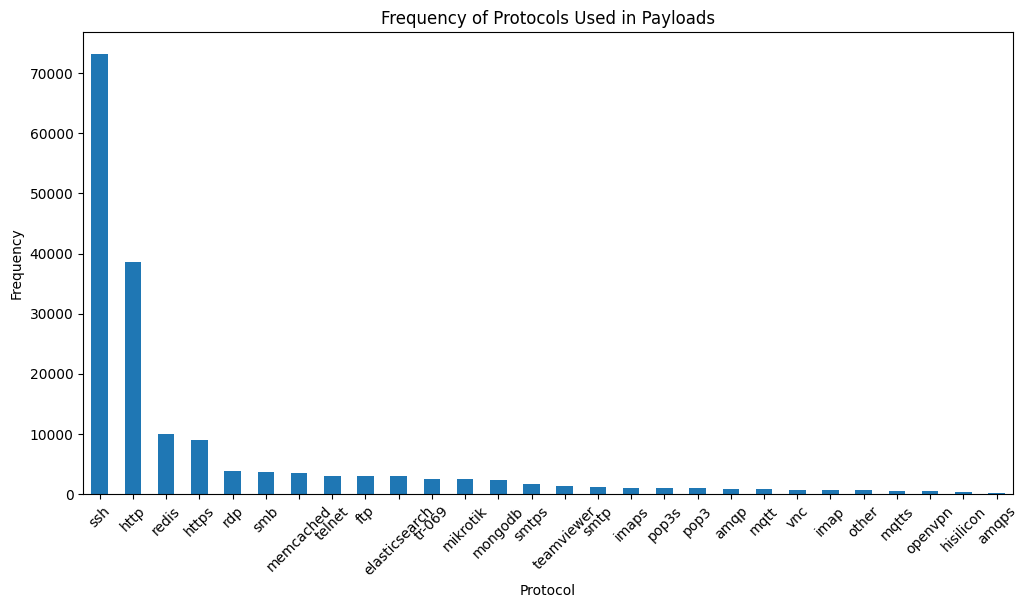

In [18]:
protocol_counts = df['protocol'].value_counts()

plt.figure(figsize=(12, 6))
protocol_counts.plot(kind='bar')
plt.title('Frequency of Protocols Used in Payloads')
plt.xlabel('Protocol')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [19]:
df

,src_port,dst_port,timestamp,src_as,src_city,src_country,src_countryCode,src_geo_str,src_ip,src_proxy,...,dst_oct1,dst_oct2,dst_oct3,dst_oct4,pl_length,pl_unique_bytes,pl_entropy,pl_mean_byte,pl_std_byte,payload_decoded
2,13652,22,2025-04-06 07:32:11.683,AS6939 Hurricane Electric LLC,Alameda,United States,US,"[-122.262, 37.7688]",184.105.247.252,False,...,216,238,89,44,205.0,58.0,5.483701,71.009756,31.568430,SSH_FULL: GET / HTTP/1.1\r\nHost: 216.238.89.4...
5,60497,22,2025-04-06 07:32:16.244,AS6939 Hurricane Electric LLC,Fremont,United States,US,"[-121.931, 37.49]",64.62.197.112,False,...,104,238,179,29,204.0,57.0,5.442605,70.068627,31.628127,SSH_FULL: GET / HTTP/1.1\r\nHost: 104.238.179....
12,38560,80,2025-02-05 09:02:11.049,"AS14061 DigitalOcean, LLC",Singapore,Singapore,SG,"[103.695, 1.32123]",128.199.179.71,False,...,45,32,124,12,113.0,40.0,5.007355,76.964602,35.198785,HTTP_FULL:\nGET /hello HTTP/1.1\r\nHost: cf.06...
18,48162,443,2025-02-05 09:02:21.314,AS63949 Akamai Connected Cloud,Fremont,United States,US,"[-122.0004, 37.5625]",45.33.109.8,False,...,216,238,86,69,110.0,40.0,5.088686,70.363636,34.515274,HTTP_FULL:\nGET / HTTP/1.1\r\nHost: 216.238.86...
21,42914,80,2025-02-05 09:02:23.899,"AS14061 DigitalOcean, LLC",Singapore,Singapore,SG,"[103.695, 1.32123]",128.199.170.18,False,...,45,32,124,12,113.0,40.0,5.007355,76.964602,35.198785,HTTP_FULL:\nGET /hello HTTP/1.1\r\nHost: cf.06...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965074,42792,22,2025-03-31 23:57:36.661,AS12400 Partner Communications Ltd.,Jerusalem,Israel,IL,"[35.2186, 31.7674]",84.95.208.63,False,...,95,179,186,46,12.0,10.0,3.251629,56.416667,27.941780,SSH-2.0-Go
965075,42786,22,2025-03-31 23:57:36.525,AS12400 Partner Communications Ltd.,Jerusalem,Israel,IL,"[35.2186, 31.7674]",84.95.208.63,False,...,95,179,186,46,12.0,10.0,3.251629,56.416667,27.941780,SSH-2.0-Go
965076,42776,22,2025-03-31 23:57:36.396,AS12400 Partner Communications Ltd.,Jerusalem,Israel,IL,"[35.2186, 31.7674]",84.95.208.63,False,...,95,179,186,46,12.0,10.0,3.251629,56.416667,27.941780,SSH-2.0-Go
965077,53924,443,2025-03-31 23:57:57.010,"AS16509 Amazon.com, Inc.",Dublin,United States,US,"[-83.1141, 40.0992]",3.136.87.118,False,...,95,179,201,146,12.0,10.0,3.251629,56.416667,27.941780,HTTP_FULL:\nSSH-2.0-Go


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

# Load model & tokenizer from Hugging Face
model_name = "fdtn-ai/Foundation-Sec-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to construct prompt
def build_prompt(payload: str) -> str:
    return (
        "You are a cybersecurity expert. Analyze the following HTTP payload and determine "
        "if it is part of a cyberattack.\n"
        "If it is malicious, identify the type of attack from the following classes:\n"
        "- BruteForce\n- DDoS\n- DoS\n- Other (heartbleed, infiltration, bot)\n- Scan\n- WebAttack\n\n"
        f"Payload:\n{payload}\n\n"
        "Respond only with the attack class and a short explanation."
    )

# Function to get model response
@torch.no_grad()
def query_model(prompt: str, max_new_tokens: int = 150) -> str:
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    output = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
        )
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    return decoded[len(prompt):].strip()

# Apply model to each payload
results = []
for payload in tqdm(df["payload_decoded"][:5].fillna("").tolist(), desc="Analyzing payloads"):
    prompt = build_prompt(payload)
    prediction = query_model(prompt)
    results.append(prediction)

# Save predictions
df["foundation_pred"] = results

Analyzing payloads:   6%|▌         | 11/200 [1:23:11<23:49:30, 453.81s/it]


KeyboardInterrupt: 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load Foundation-Sec-8B model and tokenizer
model_name = "fdtn-ai/Foundation-Sec-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
)
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Build your custom prompt here
payload = """   T SMBr      (              /K   ^ 1  LANMAN1.0  LM1.2X002  NT LANMAN 1.0  NT LM 0.12"""

prompt = (
    "Analyze the following payload and determine "
    "if it is part of a cyberattack.\n"
    "If it is malicious, identify the type of attack from the following classes:\n"
    "- BruteForce\n- DDoS\n- DoS\n- Other (heartbleed, infiltration, bot)\n- Scan\n- WebAttack\n\n"
    f"Payload:\n{payload}\n\n"
    "Respond only with the attack class and a short explanation."
)

# Inference
@torch.no_grad()
def query_model(prompt: str, max_new_tokens: int = 150) -> str:
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    output = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        eos_token_id=tokenizer.eos_token_id
    )
    decoded = tokenizer.decode(
        output[0], 
        skip_special_tokens=True, 
        skip_prompt=True
    )    
    return decoded.strip()

# Run and print result
result = query_model(prompt)
print("Model Prediction:\n", result)


Loading checkpoint shards: 100%|██████████| 4/4 [00:52<00:00, 13.10s/it]
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Model Prediction:
 Analyze the following payload and determine if it is part of a cyberattack.
If it is malicious, identify the type of attack from the following classes:
- BruteForce
- DDoS
- DoS
- Other (heartbleed, infiltration, bot)
- Scan
- WebAttack

Payload:
   T SMBr      (              /K   ^ 1  LANMAN1.0  LM1.2X002  NT LANMAN 1.0  NT LM 0.12

Respond only with the attack class and a short explanation.


In [21]:
result

''